https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid  
https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/unet.py  
https://github.com/yandex-research/ddpm-segmentation  
Code from: https://huggingface.co/blog/annotated-diffusion

- register hook : https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/



In [1]:
import math
import numpy as np
from inspect import isfunction
from functools import partial
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

from torch.utils.data import DataLoader

from accelerate import Accelerator

from torch.optim import Adam

from torchmetrics.classification import BinaryJaccardIndex

from kornia.geometry.transform import resize

from sklearn.model_selection import train_test_split
import cv2

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
def exists(x):
    return x is not None #Boolean

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim_in, dim_out = None):
    return nn.ConvTranspose2d(dim_in, default(dim_out,dim_in), 4, 2, 1)


"""
def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )

"""

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


In [4]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)


In [5]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


In [7]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2) #42
       
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] #42, 64, 128, 256
        
        in_out = list(zip(dims[:-1], dims[1:])) #Zip pairs of in out dims together
        out_in = list(zip(reversed(dims[1:]), reversed(dims[:-1])))[:-1]   
        
        self.extract_list = None
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        
        
        for ind, (dim_in, dim_out) in enumerate(in_out):

            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        
        for ind, (dim_in, dim_out) in enumerate(out_in):
            is_last = ind >= (num_resolutions - 1)
            
        

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in,dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(2*dim, dim), nn.Conv2d(dim, out_dim, 1)
        )
        


    def forward(self, x, time, extract_feature = False):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None
         

        h = []
        l = []

        # downsample

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
   

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        
        if extract_feature:
            l = Upsample_seg(x)
        
        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            if extract_feature:
                l = torch.cat((l,Upsample_seg(x)), dim = 1)
    
            x = upsample(x)


        x = torch.cat((x, h.pop()), dim=1)
        x = self.final_conv(x)
        if extract_feature:
            self.extract_list = torch.cat((l,x), dim = 1)
        return x

    
    

In [8]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

def beta_schedule_fn(timesteps, variant = "linear", s=0.008):
    if variant == "linear":
        return linear_beta_schedule(timesteps)
    elif variant == "cosine":
        return cosine_beta_schedule(timesteps, s=0.008)
    elif variant == "quadratic":
        return quadratic_beta_schedule(timesteps)
    elif variant == "sigmoid":
        return sigmoid_beta_schedule(timesteps)
    else:
        raise ValueError(f'unknown beta schedule {variant}')
        

In [9]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    #out = a.gather(-1, t.cpu())
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


class GaussianDiffusion(nn.Module):
    def __init__(self,model,*,device, 
                 image_size, timesteps = 10, 
                 beta_schedule = "linear",
                 objective = "pred_noise",
                 loss_type = 'l1', dtype = torch.float32):
        super().__init__()
        
        
        self.loss_type = loss_type
        self.model = model                    #For U-net
        self.channels = self.model.channels   #For U-net
        self.image_size = image_size
        
        assert objective in {'pred_noise', 'pred_x0'}
        self.objective = objective
        
        self.device = device
        betas = beta_schedule_fn(timesteps, beta_schedule).type(dtype).to(device) # Get betas and cast them at as float32
        self.betas = betas
        alphas = 1. - betas # Get alphas
        alphas_cumprod = torch.cumprod(alphas, dim=0)   #Get alpha bar
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)
        
        self.alphas_cumprod_prev = alphas_cumprod_prev
        
        self.num_timesteps = int(timesteps)  #Save timesteps in class
        
        self.loss_type = loss_type           
        
        # calculations for diffusion q(x_t | x_{t-1}) and others use buffers for float64 to float32?
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)            #Square root of alpha bar
        self.sqrt_alphas_cumprod_prev = torch.sqrt(alphas_cumprod_prev)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)   #Sqrt(1 - alpha bar)
        self.log_one_minus_alphas_cumprod = torch.log(1 - alphas_cumprod)#log(1 - alpha bar)
        self.sqrt_recip_alphas_cumprod = 1. / alphas_cumprod
        #self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / alphas_cumprod - 1)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
        

        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) #beta tilde
        self.posterior_variance = posterior_variance
        
        
        
        
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        # then by "clipping" we exhange the 0 with a VERY small number like 1e-20.
        #self.posterior_log_variance_clipped =  torch.log(posterior_variance.clamp(min =1e-20))
        #self.posterior_mean_coef1 =  betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)    #coef for x0 in mean
        #self.posterior_mean_coef2 = (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod) #coef for x1 in mean
       
            
    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data (t == 0 means diffused for 1 step)
        """
        if noise is None:
            noise = torch.randn_like(x_start, device = self.device)
        
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +         # q(x_t | x_0)
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise   # Sample with x_t = mu + sd*eps
        )

    def p_losses(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start, device = self.device)
            

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_out = self.model(x_noisy, t)
        
        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        

        if self.loss_type == 'l1':
            loss = F.l1_loss(target, model_out)
        elif self.loss_type == 'l2':
            loss = F.mse_loss(target, model_out)
        elif self.loss_type == "huber":
            loss = F.smooth_l1_loss(target, model_out)
        else:
            raise NotImplementedError()

        return loss
    

        
    @torch.no_grad()
    def p_sample(self, x, t, t_index):
        betas_t = extract(self.betas, t, x.shape)

        # Equation 11 in the paper
        # Use our model (noise predictor) to predict the mean
        
        pred = self.model(x, t)
        
        if self.objective == "pred_noise":
            sqrt_one_minus_alphas_cumprod_t = extract(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
            )
            sqrt_recip_alphas_t = extract(self.sqrt_recip_alphas, t, x.shape)
            
            model_mean = sqrt_recip_alphas_t *(x - betas_t * pred / sqrt_one_minus_alphas_cumprod_t)
        elif self.objective == "pred_x0":
            
            sqrt_recip_one_min_alphas_cumprod = 1. / extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_alphas_cumprod_prev = extract(self.sqrt_alphas_cumprod_prev, t, x.shape)
            alphas_cumprod_prev = extract(self.alphas_cumprod_prev,t, x.shape)
            sqrt_alphas_t = torch.sqrt(1. - betas_t)
            
            model_mean = sqrt_recip_one_min_alphas_cumprod * (sqrt_alphas_cumprod_prev* betas_t*pred + \
                                                     sqrt_alphas_t*(1. - alphas_cumprod_prev)*x)
        
        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = extract(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            # Algorithm 2 line 4:
            return model_mean + torch.sqrt(posterior_variance_t) * noise 

    # Algorithm 2 (including returning all images)
    @torch.no_grad()
    def p_sample_loop(self, shape):
        device = next(self.model.parameters()).device

        b = shape[0]
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []

        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long), i)
            imgs.append(img.cpu().numpy())
        return imgs

    @torch.no_grad()
    def sample(self, batch_size=16, channels=1):
        return self.p_sample_loop(shape=(batch_size, channels, self.image_size, self.image_size))


    
    def forward(self, img, *args, **kwargs):
        batch_size = img.size()[0]
        t = torch.randint(0, self.num_timesteps, (batch_size,), device= self.device).long()
        
        return self.p_losses(img, t)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
from kornia.geometry.transform import resize

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

data = torch.load("lungData.pt") #Loading preprocessed data
XRAY, mask = data

XRAY = XRAY.to(device)
image_size = 64

batch_size = 32 

XRAY_resized = normalize_to_neg_one_to_one(resize(XRAY,(image_size,image_size)))
mask_resized = resize(mask,(image_size,image_size))

In [12]:
def getActivation(number, activation):
  # the hook signature
    def hook(model, input, output):
        activation[number] = output.detach()
    return hook

@torch.no_grad()
def Upsample_seg(feats, size = 64):
    return nn.functional.interpolate(feats, size=size, mode="bilinear")

In [13]:
from typing import List
class FeatureExtract(nn.Module):
    def __init__(self, diffusion, timesteps: List[int] , blocks: List[int]):
        # My Unet has blocks = [1,2,3,4,5,6,7,8]
        super().__init__()
        self.diffusion = diffusion
        self.timesteps = timesteps
        self.model = diffusion.model
        self.model.eval()
        self.features = {}                                                         
        # Save decoder activations
        i = 1
        for block_list in self.model.ups:
            for block in block_list:
                if i in blocks:
                    block.register_forward_hook(getActivation(i,self.features))
                i += 1
    
    @torch.no_grad()
    def forward(self, x, noise=None):
        activations = []
        for t in self.timesteps:
            # Compute x_t and run DDPM
            t = torch.tensor([t]).to(x.device)
            noisy_x = self.diffusion.q_sample(x, t, noise=noise)
            self.model(noisy_x, t)
            
            #Save actions for timestep t
            activations_t = []
            
            for key in self.features.keys():
                activations_t.append(Upsample_seg(self.features[key].cpu())) #Upsamle to 64 x 64
            
            activations.append(activations_t)

        # Per-layer list of activations [Timestep x Block x Batch x C x H x W]
        return activations 

In [14]:
from sklearn.cluster import KMeans

def reshape_v2(x):
    if x.is_cuda == True:
        x = x.cpu()
    return rearrange(x, "c b w -> (b w) c")

def km(X , k = 2, init = "random"):
    if X.is_cuda == True:
        X = X.cpu()
    if X.requires_grad == True:
        X = X.detach().numpy()
    size = (X.shape[1],X.shape[2])
    X = rearrange(X, "c b w -> (b w) c")
    
    pred = KMeans(n_clusters = k, init = init, random_state= 0).fit(X)
    lb = pred.labels_.reshape(size)
    
    if lb[0][0] == 0:
        """If the top left corner is labeled 0 (black) we swap 0 and 1 label
            since the background and the lungs is very likely to get the same labels.
            It works best if k = 2""" 
        lb = (lb - 1)*(-1) 
    return lb


def km_plot(X, pred, mask, mode = 1, mask_bin = True, axis = "off", post_process = False):
    assert mode in [1,2], "Only mode 1 or 2 is supported"
    if len(mask.size()) == 3:
         mask =  mask[0]
    if mask_bin:
         mask = torch.round(mask)
    if type(X) != np.ndarray:
        if X.is_cuda == True:
            X = X.cpu().numpy()
    if mask.is_cuda == True:
        mask =  mask.cpu()
    if len(X.shape) == 3:
        X = X[0]
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
    
    if mode == 1:
        titles = ['Original image','K-means', 'mask']
    if mode == 2:
        titles = ['KM on OG image','KM on activation', 'True mask']
    
    ax1.set_title(titles[0])
    ax1.imshow(X, cmap = "gray"),ax1.axis(axis)
    ax2.set_title(titles[1])
    ax2.imshow(pred, cmap = "gray"),ax2.axis(axis)
    ax3.set_title(titles[2])
    ax3.imshow(mask,cmap = "gray"),ax3.axis(axis)
    s = "No post-processing"
    if post_process:
        s = "Post-processing (2)"
    f.suptitle(s, fontsize=16)

def postprocess(kmeans, n_max_extract= 2):
    kmeans = 255*kmeans.astype("uint8")
    num_labels, labels = cv2.connectedComponents(kmeans)
    occ_labels = np.bincount(labels.flat)[1:] #Count label
    if n_max_extract == 1 or (occ_labels.size == 1):
        largest_labels = np.argpartition(occ_labels, -1)[-1:] + 1 #Extract largest or two largest labels
        kmeans = (labels == largest_labels) #Largest compontents (and if there is only one)
    elif n_max_extract == 2:
        largest_labels = np.argpartition(occ_labels, -2)[-2:] + 1
        kmeans = (labels == largest_labels[0]) | (labels == largest_labels[1]) #Extract two largest compontents
    return kmeans    
    
def metric(k_means, mask, use_postprocess = True, n_max_extract = 2):
    # If use_postprocess is true a connected component analysis is
    # run on the k_means array and either the largest or the two
    # largest components is extracted
    
    assert n_max_extract in [1,2], 'only extract largest or two largest components'
    
    if len(mask.size()) == 3:
        mask = mask[0]
    mask = mask.round()
    if use_postprocess:
        k_means = postprocess(k_means, n_max_extract = n_max_extract)
    #plt.imshow(k_means, cmap = "gray") #For testing
    
    k_means = torch.from_numpy(k_means)
    IoU = BinaryJaccardIndex()
    
    return IoU(k_means, mask)   

In [15]:
def experiment(X,y,diffusion, timesteps : List[int], blocks: List[int], k = 2, print_per = 50):
    batch = X.size()[0]
    time = len(timesteps)
    block_length = len(blocks)
    FE = FeatureExtract(diffusion, timesteps, blocks)
    activations = FE(X)
    IoUs = np.zeros(shape = (batch,3,block_length + 1,time)) #Batch x Options x Blocks (+ all) x timesteps
    for t in range(time):
        if t % print_per == 0:
            print("timestep: ", timesteps[t])
        for b in range(block_length):
            for bt in range(batch):
                act = activations[t][b][bt]
                
                kmeans = km(act, k = k)

                IoUs[bt][0][b][t] = metric(kmeans,y[bt], use_postprocess=False)
                IoUs[bt][1][b][t] = metric(kmeans,y[bt], use_postprocess=True, n_max_extract=1) 
                IoUs[bt][2][b][t] = metric(kmeans,y[bt], use_postprocess=True, n_max_extract=2)
        
        #Collect all the features
        act_all = torch.cat(activations[t], dim= 1)
        for bt in range(batch):
            kmeans = km(act_all[bt], k = k)
            
            IoUs[bt][0][-1][t] = metric(kmeans,y[bt], use_postprocess=False)
            IoUs[bt][1][-1][t] = metric(kmeans,y[bt], use_postprocess=True, n_max_extract=1) 
            IoUs[bt][2][-1][t] = metric(kmeans,y[bt], use_postprocess=True, n_max_extract=2)
            
        
    return IoUs #Batch x Options x Blocks (+ all) x timesteps


def baseline(X,y):
    batch = X.size()[0]
    IoU_baseline = np.zeros(shape = (batch,3))

    for i in range(batch):
        kmeans = km(X[i])
        IoU_baseline[i][0] = metric(kmeans, y[i], use_postprocess=False)
        IoU_baseline[i][1] = metric(kmeans, y[i], use_postprocess=True, n_max_extract=1)
        IoU_baseline[i][2] = metric(kmeans, y[i], use_postprocess=True, n_max_extract=2)
    
    return IoU_baseline.mean(axis = 0) 

def mIoU_fn(X,y,diffusion, timesteps : List[int], blocks: List[int], k = 2, 
            rounds = 5, mini_batch = 20,time_sliced = 50, print_per = 50):
    if rounds == 1:
        t = list(range(0,len(timesteps) + time_sliced,time_sliced))
        l = []
        for i in range(len(t) - 1):
            t_list = list(range(t[i],t[i+1]))
            l.append(experiment(X,y, diffusion, timesteps = t_list, blocks = blocks,k = k, print_per = print_per))
            
        return (np.concatenate(l, axis = -1)).mean(axis = 0)
    batch = X.size()[0]
    block_length = len(blocks)
    time_length = len(timesteps)
    
    data = np.zeros(shape= (rounds,mini_batch,3,
                            block_length + 1,time_length))  # Rounds x mini_Batch x Option x blocks (+ 1) x timesteps
    for i in range(0,batch,mini_batch):
        print("Part", int(batch / i) + 1)
        t = list(range(0,len(timesteps) + time_sliced,time_sliced))
        l = []
        for i in range(10):
            t_list = list(range(t[i],t[i+1]))
            l.append(experiment(X[i:(i+mini_batch)],y[i:(i+mini_batch)], diffusion, 
                                timesteps = t_list, blocks = blocks,k = k, print_per = print_per))
            
        data[i] = np.concatenate(l, axis = -1)
    
    data = rearrange(data, "s b o l t -> (s b) o l t")
    return data.mean(axis = 0)

In [32]:
torch.manual_seed(999)

batch_size = 20

diffusion = torch.load("model_e10K_t1K_seg")

X,_, y,_ = train_test_split(XRAY_resized, mask_resized, 
                                             train_size = batch_size, shuffle = True,
                                             random_state = 0) #Sample data from dataset
timesteps =  list(range(1000))
blocks = list(range(1,9))

bl = baseline(X,y)
mIoU = mIoU_fn(X,y,diffusion,timesteps,blocks, rounds = 1)

timestep:  0
timestep:  50
timestep:  100
timestep:  150
timestep:  200
timestep:  250
timestep:  300
timestep:  350
timestep:  400
timestep:  450
timestep:  500
timestep:  550
timestep:  600
timestep:  650
timestep:  700
timestep:  750
timestep:  800
timestep:  850
timestep:  900
timestep:  950


In [297]:
from matplotlib.pyplot import figure

#figure(figsize=(10, 8), dpi=80)

def data_plotter(data, base_line, option = 0, fig_size = (10,8),
                 dpi = 100, max_baseline = False, n_samples = None,
                blocks = list(range(1,10))):
    figure(figsize=fig_size, dpi=dpi)
    timesteps = data.shape[-1]
    blocks = [b-1 for b in blocks] #Change notation (Block 1 has index 0)
    time_series = np.arange(timesteps)
    titles = ["No postprocessing","Postprocessing with only one lcc extracted","Postprocessing with two lcc extracted"]
    fig = plt.figure(1)
    figure(fig,figsize=(10, 8), dpi=80)
    colors = ["lawngreen","b","m","g","cyan", "darkorange", "indigo", "gold","slategray"]
    for i in blocks:
        plt.plot(time_series,data[option][i], c = colors[i])
    if max_baseline:
        base_line_max = [base_line.max()]*3 #Use the maximum baseline
        blt_val = base_line_max[option]
        if blt_val != base_line[option]: #If this baseline not is max
            plt.plot(time_series,[base_line_max[option]]*timesteps, c = "red", ls = "--")
            plt.plot(time_series,[base_line[option]]*timesteps, c = "black", ls = "--")
        else:
            plt.plot(time_series,[base_line[option]]*timesteps, c = "red", ls = "--")
    else:
        plt.plot(time_series,[base_line[option]]*timesteps, c = "black", ls = "--")
                     
                     
            
    #Legend
    handles = []
    
    for i in blocks[:-1]:
        handles.append(mpatches.Patch(color = colors[i], label = "block " + str(i+1)))
    
    #All blocks concat
    handles.append(mpatches.Patch(color="slategray", label = "All blocks"))  
    #Baseline(s)  
    s = ""
    c = "red"
    if max_baseline:
        if blt_val != base_line[option]:
            handles.append(mpatches.Patch(color="black", label = "baseline", linestyle = "--", fill = False))
            s = "max "
    else:
        c = "black"

    
    handles.append(mpatches.Patch(color=c, label = s + "baseline", linestyle = "--", fill = False))
    plt.legend(handles = handles)
    plt.title(titles[option])
    plt.xlabel("timesteps")
    if not n_samples:
        n_samples = ""
    else:
        n_samples = "(of " + str(n_samples) + " samples)" 
    plt.ylabel("mIoU " + str(n_samples)) 
    plt.ylim(0,0.35)

In [66]:
torch.manual_seed(999)
X,_, y,_ = train_test_split(XRAY_resized, mask_resized, 
                                             train_size = 20, shuffle = True,
                                             random_state = 0) #Sample data from dataset
bl = baseline(X,y)
mIoU = torch.load("mIoU_20")
bl

array([0.3176976 , 0.1852646 , 0.22428373])

In [19]:
#torch.save(mIoU, "mIoU_20")

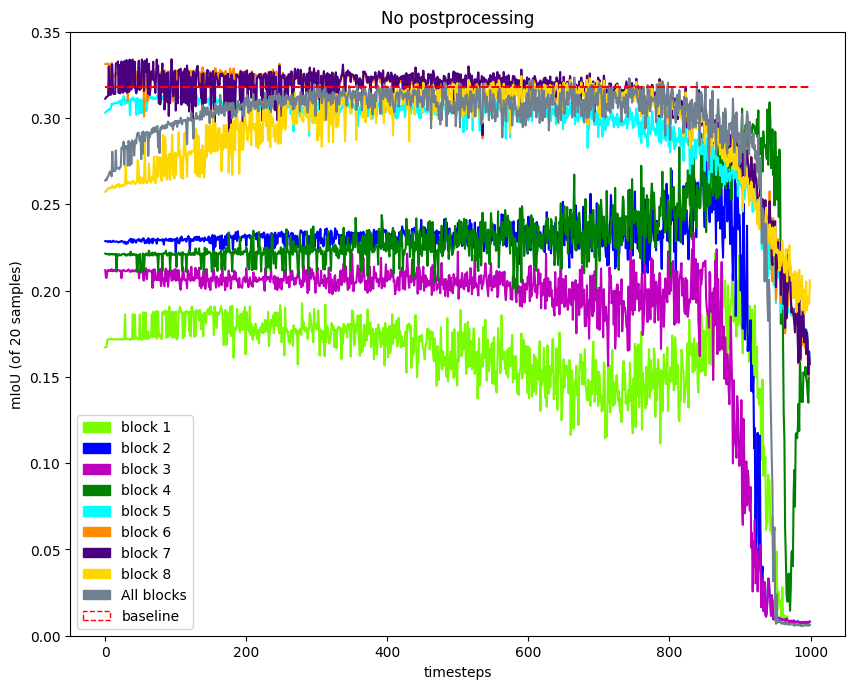

In [298]:
data_plotter(mIoU,bl, option = 0, n_samples=20, max_baseline=True)

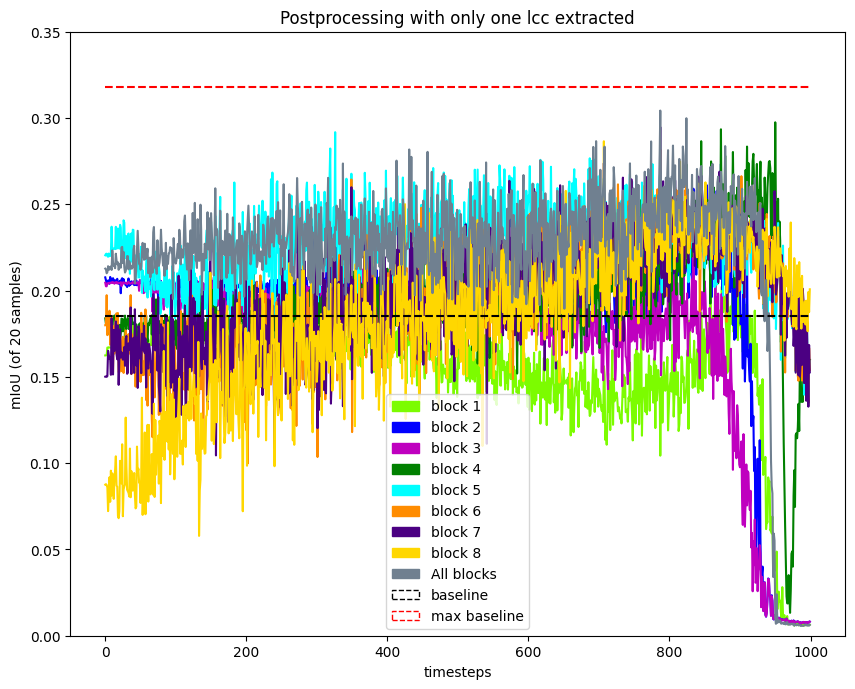

In [299]:
data_plotter(mIoU,bl, option = 1, n_samples=20, max_baseline=True)

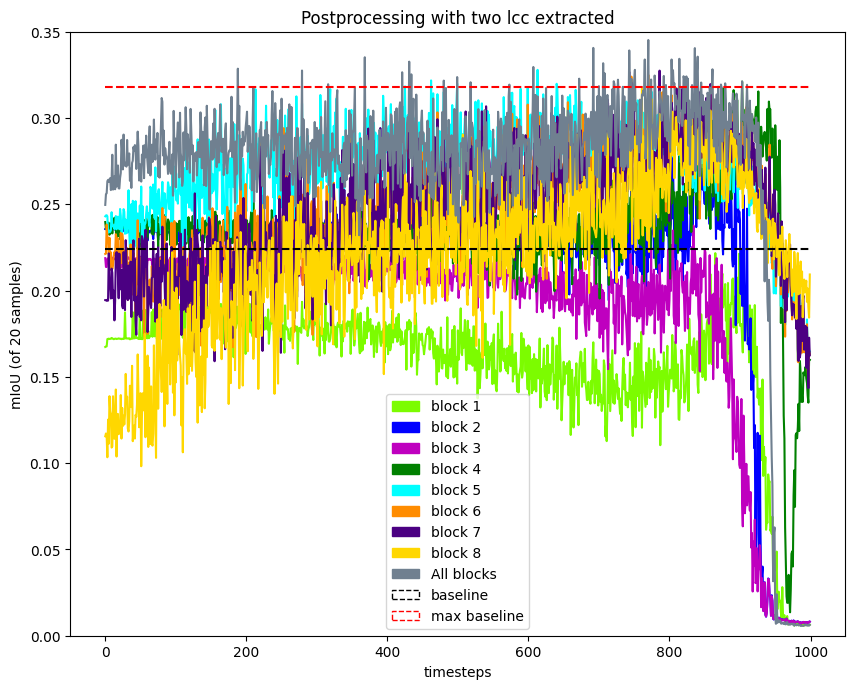

In [300]:
data_plotter(mIoU,bl, option = 2, n_samples=20, max_baseline=True)

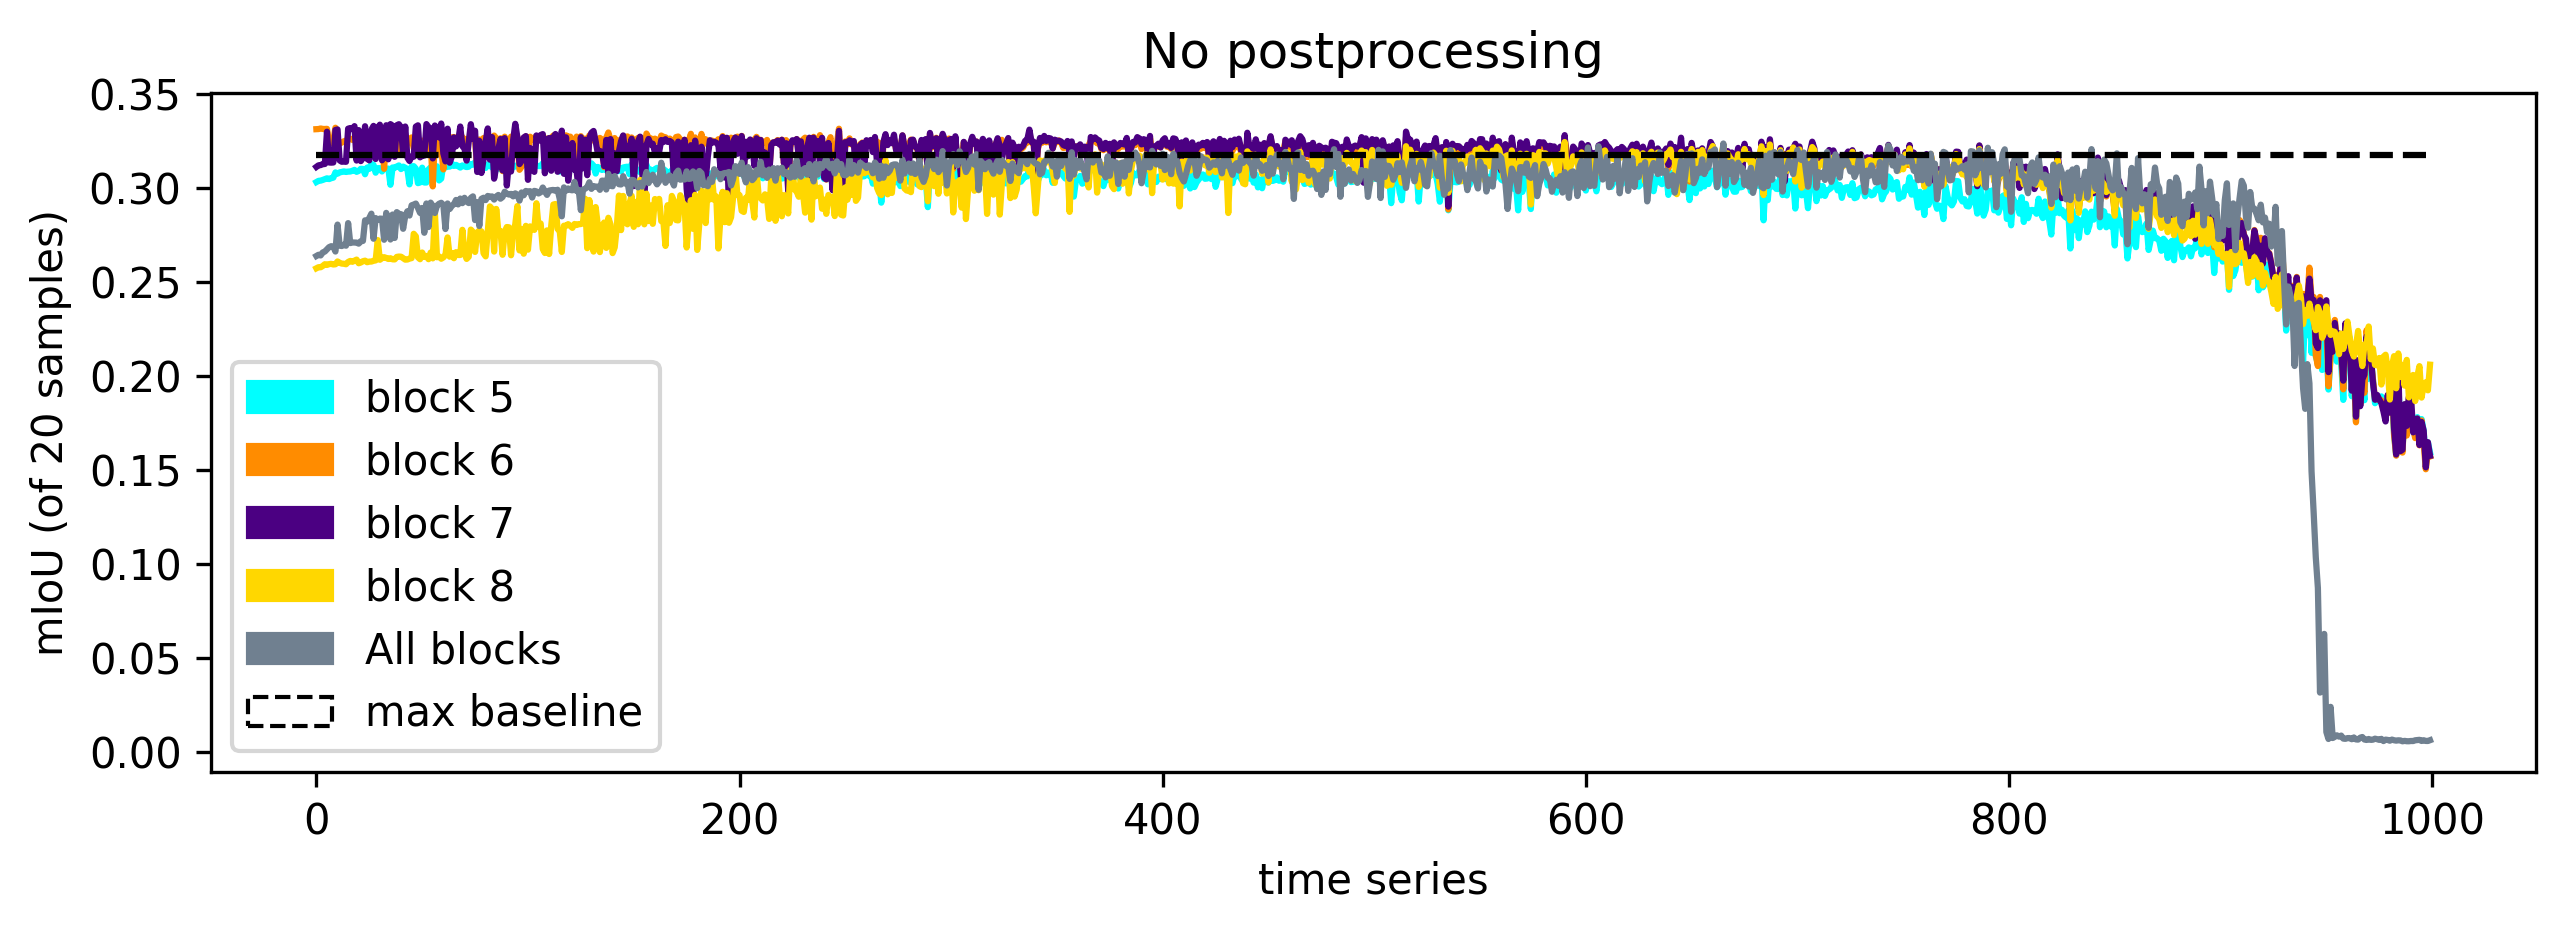

In [40]:
data_plotter(mIoU,bl,option = 0, max_baseline=True, blocks=[5,6,7,8,9], fig_size = (10,3), dpi = 300, n_samples= 20)

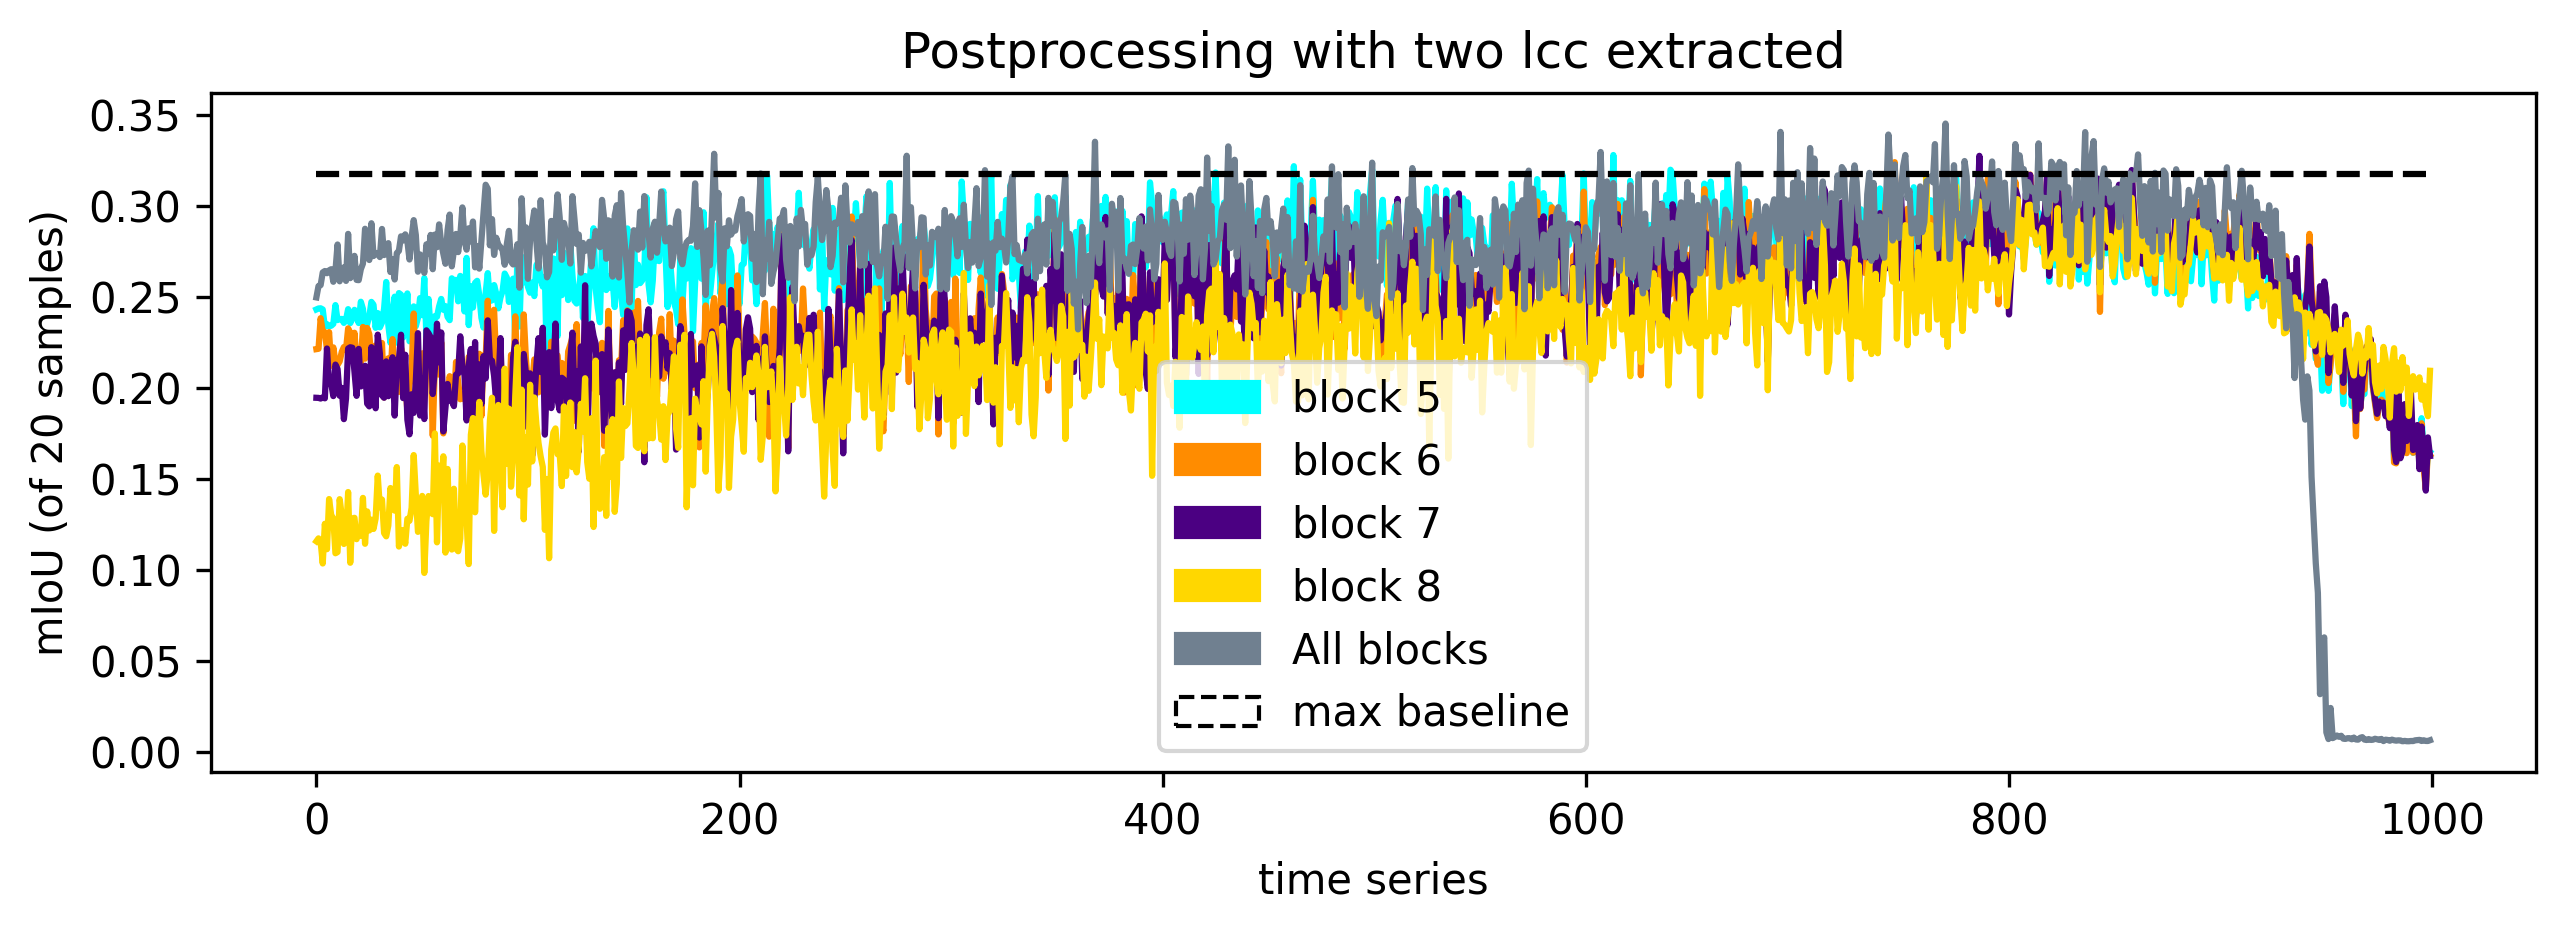

In [41]:
data_plotter(mIoU,bl,option = 2, max_baseline=True, blocks=[5,6,7,8,9], fig_size = (10,3), dpi = 300, n_samples= 20)

In [18]:
#max mIoU
option, block, t = np.unravel_index(mIoU.argmax(), mIoU.shape)
block = block + 1
print(option,block, t)

2 9 770


In [28]:
mIoU.max()

0.3451997898519039

In [14]:
diffusion =  torch.load("model_e10K_t1K_seg")

In [21]:
best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=blocks)
best_act = best_feat(X)

NameError: name 'blocks' is not defined

In [196]:
def km_plot2(X, act, mask, 
             mask_bin = True, axis = "off", post_process = False,
            timesteps = [50,250,500,750], block = 9, n = 0, fig_size = (10,8),
             dpi = 80):
    if len(mask.size()) == 3:
         mask =  mask[0]
    if mask_bin:
         mask = torch.round(mask)
    #if type(X) != np.ndarray:
     #   if X.is_cuda == True:
    #        X = X.cpu().numpy()
    if mask.is_cuda == True:
        mask =  mask.cpu()
    #if len(X.shape) == 3:
    #    X = X[0]
    #fig = plt.figure(1)
    #figure(fig,figsize=fig_size, dpi=dpi)
    #f, axes = plt.subplots(1, len(timesteps) + 2, sharey=True)
    titles = ['Image']
    kmeans_list = [km(X)]
    for t_index, t in enumerate(timesteps):
        titles.append("Timestep " + str(t))
        if block == 9:
            act_all = torch.cat(act[t_index], dim = 1)
            kmeans = km(act_all[n], k = k)
        else:
            kmeans = km(act[t_index][block - 1][n], k = k)
        kmeans_list.append(kmeans)
    titles.append('True mask')
    kmeans_list.append(mask)
     
    print("Block",block)
    for i in range(len(timesteps) + 2):
        plt.title(titles[i])
        plt.imshow(kmeans_list[i], cmap = "gray"),plt.axis(axis)
        plt.show()
    s = "No post-processing"
    if post_process:
        s = "Post-processing (2)"
    #f.suptitle(s, fontsize=16)

In [269]:
blocks = list(range(1,9))
timesteps = [50,200,500,750]
batch_size = 2
X,_, y,_ = train_test_split(XRAY_resized, mask_resized, 
                                             train_size = batch_size, shuffle = True) #Sample data from dataset

FE = FeatureExtract(diffusion,blocks= blocks, timesteps = timesteps)
act = FE(X[0])

In [270]:
act = FE(X[0])

In [296]:
torch.cat(act[0], dim = 1).size()

torch.Size([1, 1344, 64, 64])

Block 9


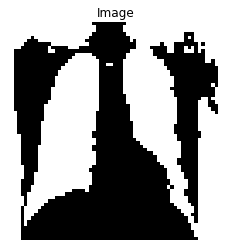

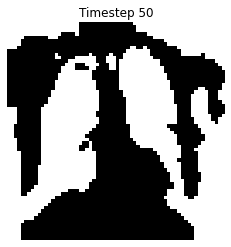

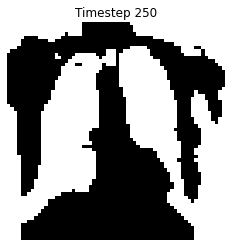

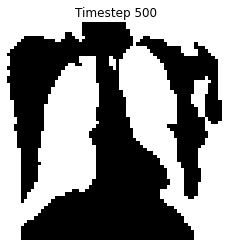

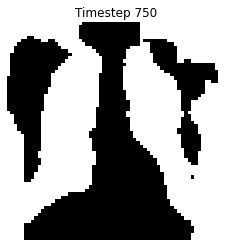

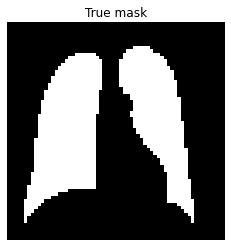

In [282]:
km_plot2(X[0],act, y[0], block = 9, fig_size=(20,10), dpi = 100)

In [259]:
X2,_, y2,_ = train_test_split(XRAY_resized, mask_resized, 
                                             train_size = batch_size, shuffle = True, random_state = 0 ) #Sample data from dataset

FE = FeatureExtract(diffusion,blocks= blocks, timesteps = timesteps)
act = FE(X2[0])

Block 9


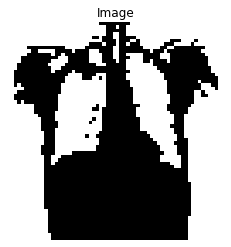

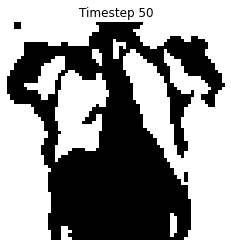

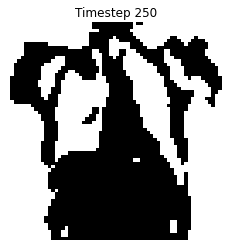

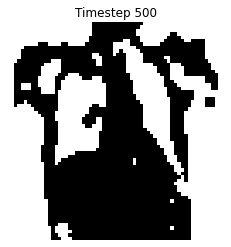

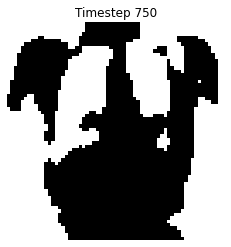

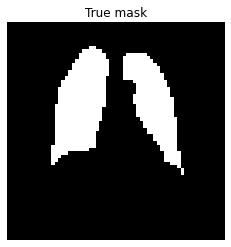

In [290]:
act = FE(X2[0])
km_plot2(X2[0],act, y2[0], block = 9, fig_size=(20,10), dpi = 100)

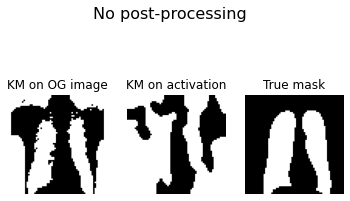

In [113]:
torch.manual_seed(999)
b = 2
block = 1
t = 500
option = 0
post_process = False

if block == 9:
    blocks = list(range(1,9))
    best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=blocks)
    best_act = best_feat(X)
    best_act = torch.cat(best_act[0], dim = 1)
else:
    best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=[block])
    best_act = best_feat(X)[0][0]

kmeans = km(best_act[b])
if post_process:
    kmeans = postprocess(kmeans,n_max_extract=option)
km_plot(km(X[b]),kmeans,y[b], mode = 2, post_process = post_process, axis = "off")

(<matplotlib.image.AxesImage at 0x1b5800ff340>, (-0.5, 63.5, 63.5, -0.5))

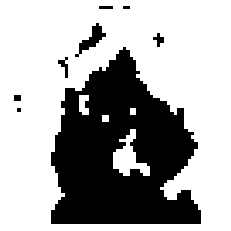

In [157]:
block = 4
k = 2
torch.manual_seed(999)
t_index = 3
n = 0


if block == 9:
    act_all = torch.cat(act[t_index], dim = 1)
    kmeans = km(act_all[n], k = k)
else:
    kmeans = km(act[t_index][block - 1][n], k = k)
    
plt.imshow(kmeans,cmap = "gray"),plt.axis("off")

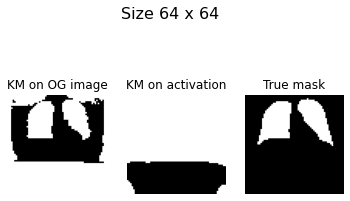

In [25]:
block = 9
k = 2
torch.manual_seed(999)
b = 9

if block == 9:
    blocks = list(range(1,9))
    best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=blocks)
    best_act = best_feat(X)
    best_act = torch.cat(best_act[0], dim = 1)
else:
    best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=[block])
    best_act = best_feat(X)[0][0]

kmeans = km(best_act[b], k = k)
#kmeans = postprocess(kmeans,n_max_extract=option)
km_plot(km(X[b]),kmeans,y[b], mode = 2, axis = "off")

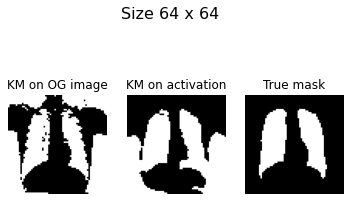

In [26]:
block = 9
k = 2
torch.manual_seed(999)
b = 11


if block == 9:
    blocks = list(range(1,9))
    best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=blocks)
    best_act = best_feat(X)
    best_act = torch.cat(best_act[0], dim = 1)
else:
    best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=[block])
    best_act = best_feat(X)[0][0]

kmeans = km(best_act[b], k = k)
kmeans = postprocess(kmeans,n_max_extract=option)
km_plot(km(X[b]),kmeans,y[b], mode = 2, axis = "off")

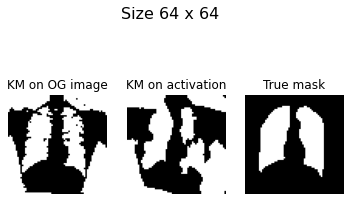

In [27]:
block = 9
k = 2
torch.manual_seed(999)
b = 4


if block == 9:
    blocks = list(range(1,9))
    best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=blocks)
    best_act = best_feat(X)
    best_act = torch.cat(best_act[0], dim = 1)
else:
    best_feat = FeatureExtract(diffusion,timesteps = [t], blocks=[block])
    best_act = best_feat(X)[0][0]

kmeans = km(best_act[b], k = k)
km_plot(km(X[b]),kmeans,y[b], mode = 2, axis = "off")

In [28]:
torch.manual_seed(999)

batch_size = 2

diffusion = torch.load("model_e10K_t1K_seg")

X,_, y,_ = train_test_split(XRAY_resized, mask_resized, 
                                             train_size = batch_size, shuffle = True,
                                             random_state = 0) #Sample data from dataset
timesteps =  [500] #list(range(1000))
blocks = list(range(1,9))


FE = FeatureExtract(diffusion,timesteps, blocks)

act = FE(X)
for block in act[0]:
    print(block.size())

torch.Size([2, 256, 64, 64])
torch.Size([2, 256, 64, 64])
torch.Size([2, 256, 64, 64])
torch.Size([2, 128, 64, 64])
torch.Size([2, 128, 64, 64])
torch.Size([2, 128, 64, 64])
torch.Size([2, 128, 64, 64])
torch.Size([2, 64, 64, 64])


In [ ]:
big_baseline = baseline(XRAY_resized,mask_resized)
big_baseline

In [14]:
diffusion = torch.load("model_e10K_t1K_seg")


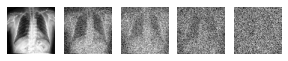

In [16]:

X = XRAY_resized[0]
#X = rearrange(X, "c b w -> 1 c b w")

step = 5
channels = 1
image_size = 64
figure = plt.figure(figsize = (10,1))
for i in range(step):
    t = torch.tensor([i*200], device = X.device)
    X_noisy = diffusion.q_sample(X,t)
    X_noisy = X_noisy.detach().cpu()
    
    figure.add_subplot(1,10,i + 1)
    plt.imshow(X_noisy.reshape(image_size, image_size, channels), cmap="gray"), plt.axis("off")

plt.show()

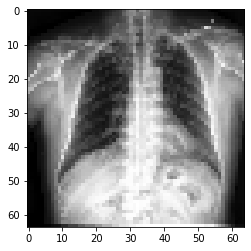

In [15]:
plt.imshow(torch.reshape(XRAY_resized[0],(64,64,1)).to("cpu"), cmap="gray")

In [30]:
t =300
X = rearrange(XRAY_resized[0], "c b w -> 1 c b w")
t = torch.tensor([t], device = X.device)
X_noisy = diffusion.q_sample(X,t)

In [19]:
X = XRAY_resized[0]
X_noisy.size()

torch.Size([1, 1, 64, 64])

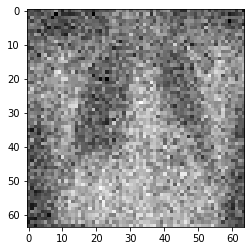

In [31]:
plt.imshow(torch.reshape(X_noisy[0],(64,64,1)).to("cpu"), cmap="gray")

In [97]:
@torch.no_grad()
def Upsample_bad(x, H_out = 64, stride = 2,padding = 1, print_kernal_size = False):
    _,dim,H_in,_ = x.size()
    device = x.device
    kernal_size = H_out + 2*padding + stride - stride*H_in
    if print_kernal_size:
        print(kernal_size)
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, dim,  kernal_size, stride = stride, padding = padding)(x)
    )

In [19]:
diffusion = torch.load("model_e10K_t1K_seg")

In [32]:
t = 500
X = rearrange(XRAY_resized[0], "c b w -> 1 c b w")
blocks = list(range(0,9))
fe = FeatureExtract(diffusion, timesteps=[t], blocks= blocks)
features = fe(X)

In [45]:
XRAY_test = normalize_to_neg_one_to_one(resize(XRAY,(16,16)))

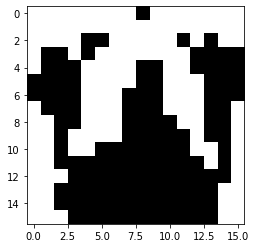

In [47]:
kmeans = km(XRAY_test[0])
plt.imshow(kmeans, cmap = "gray")

In [99]:
XRAY_test = normalize_to_neg_one_to_one(resize(XRAY,(32,32)))
X2 = rearrange(XRAY_test[0], "c b w -> 1 c b w")
test2= Upsample_bad(X2.cpu(), print_kernal_size=True)
kmeans = km(test2[0].det)
plt.imshow(kmeans, cmap = "gray")

4


TypeError: torch.FloatTensor is not a Module subclass

In [ ]:
kmeans = km(test2[0].det)
plt.imshow(kmeans, cmap = "gray")

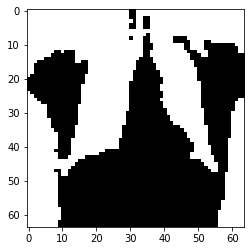

In [53]:
XRAY_test = normalize_to_neg_one_to_one(resize(XRAY,(32,32)))
X2 = rearrange(XRAY_test[0], "c b w -> 1 c b w")
test2= Upsample_seg(X2)
kmeans = km(test2[0])
plt.imshow(kmeans, cmap = "gray")

In [72]:
x = torch.tensor([1, 2, 3])
x.repeat(5, d)

tensor([1, 2, 3])

In [75]:
import torchvision
import PIL.Image as Image
import torchvision.transforms as T
def resize_rbg(x, channels = 3):
    arr = []
    trans = T.Lambda(lambda x: x.repeat(channels, 1, 1) if x.size(0)==1 else x)
    img = trans(x)
    return img

In [80]:
test1 = resize_rbg(X2[0], channels= 128)

In [81]:
test1.size()

torch.Size([128, 32, 32])

In [86]:
ups = Upsample(1)
test2 = ups(X2.cpu()).detach()

In [88]:
test2.size()

torch.Size([1, 1, 64, 64])

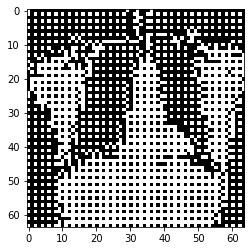

In [89]:
kmeans = km(test2[0])
plt.imshow(kmeans, cmap = "gray")

In [90]:
def Upsample2(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

In [91]:
ups = Upsample2(1)
test3 = ups(X2.cpu()).detach()

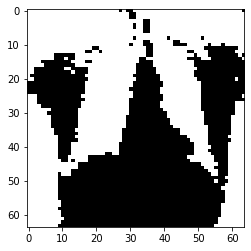

In [92]:
kmeans = km(test3[0])
plt.imshow(kmeans, cmap = "gray")

In [93]:
test4 = Upsample_seg(X2.cpu())

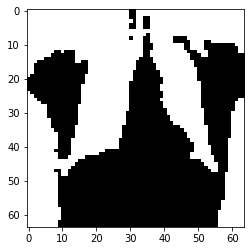

In [94]:
kmeans = km(test4[0])
plt.imshow(kmeans, cmap = "gray")

In [27]:
class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        dataset,
        device,
        *,
        batch_size = 32,
        train_lr = 1e-4,
        accelerate = False,

    ):
        super().__init__()
        
        if accelerate:
            self.accelerator = Accelerator(
            split_batches = True)
        
        self.device = device
        self.model = diffusion_model.to(device)
        self.accelerate = accelerate
        self.image_size = diffusion_model.image_size
        self.losses = np.array([])
        self.batch_size = batch_size
        self.timesteps = diffusion.num_timesteps
        
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        if accelerate:
            self.dataloader = self.accelerator.prepare(self.dataloader)
            
        
        self.opt = Adam(diffusion_model.parameters(), lr = train_lr)
        if accelerate:
            self.model, self.opt = self.accelerator.prepare(self.model, self.opt)
        
    def train(self, epochs = 100):
        device = self.device
        for epoch in tqdm(range(0, epochs), desc= "Training", total=epochs):
        #for epoch in range(epochs):
            mean_batch_loss = 0
            sum_batch_loss = 0
            for step, batch in enumerate(self.dataloader):
                self.opt.zero_grad()
        
                batch = batch.to(device)
                
            
                loss = self.model(batch)
                
                sum_batch_loss += loss.item()
                    

                if self.accelerate:
                    self.accelerator.backward(loss)
                else:
                    loss.backward()
                    
                if self.accelerate:
                    self.accelerator.wait_for_everyone()
                    
                self.opt.step()
            
            mean_batch_loss = sum_batch_loss/self.batch_size
            self.losses = np.append(self.losses, mean_batch_loss)
            if epoch % (epochs/1000) == 0:
                print("mean batch loss:", mean_batch_loss)
                
    
    def loss_plot(self):
        figure = plt.figure()
        
        epochs = len(self.losses)
        
        z = np.arange(0,epochs,1)
        plt.plot(z,self.losses, c = 'r')

        #Naming labels and title 
        plt.title("Loss for each epoch (batch mean)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
    def diffusion_plot(self, step = 20):
        
        sample = self.model.sample(batch_size = 1)
        t = self.model.num_timesteps
        
        figure = plt.figure(figsize = (step,1))

        ratio = int(self.timesteps/step)
        channels = self.model.channels
        image_size = self.model.image_size

        for i in range(t):
            if i % ratio  == 0 or i == t:
                j = int(i / ratio)
                figure.add_subplot(1,step,j + 1)
                plt.imshow(sample[i][0].reshape(image_size, image_size, channels), cmap="gray"), plt.axis("off")
        plt.show()

In [28]:
diffusion = torch.load("model_e10K_t1K_seg")
trainer = Trainer(dataset=XRAY_resized,diffusion_model = diffusion,device =  device)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

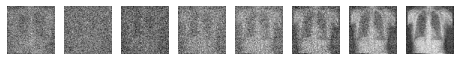

In [39]:
trainer.diffusion_plot(step = 8)

In [32]:
sample = diffusion.sample(batch_size = 1)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
from scipy import linalg

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=False)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=False)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [17]:
import torchvision
import PIL.Image as Image
import torchvision.transforms as T


def resize_rbg(batch):
    arr = []
    trans = T.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
    for img in batch:
        img = trans(img)
        pil_img = T.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(T.ToTensor()(resized_img))
    return torch.stack(arr)

def transform2(sample, image_size = 64, channels = 1):
    samples = sample[-1]
    batch = torch.zeros(1,channels,image_size,image_size)
    for i in range(len(samples)):
        x = samples[i].reshape(1, channels, image_size, image_size)
        x = torch.from_numpy(x)
        batch = torch.cat((batch,x),dim = 0)
        
    return batch[1:]


#batch = XRAY_resized[0:10]
#y = resize_rbg(batch)

In [18]:
iv3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True) # Get most updated version

Using cache found in C:\Users\chrhv/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\chrhv\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\chrhv\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
import torchvision.models as models
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
#model=model.cuda()

In [24]:
#FID of 50 data samples
from sklearn.model_selection import train_test_split
batch = 5 #Use all training data
real,_ = train_test_split(XRAY_resized, train_size = batch, shuffle = True) #Sample real data from dataset
diffusion = torch.load("model_e10K_t1K_seg")
#real = XRAY_resized.to("cpu")
real = resize_rbg(real)
# reshape batch samples...
samples = diffusion.sample(batch_size = batch)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
real = real.to("cpu")
fake = fake.to("cpu")
FID = calculate_fretchet(real, fake, model)
FID

137.1758791582875

In [ ]:
137.1758791582875

In [45]:
# Sample 704 fake images:

fake_corpus = diffusion.sample(batch_size = 4)[-1]

for i in range(0,10):
    print(i+1,"out of 10")
    sample = diffusion.sample(batch_size=70)[-1]
    fake_corpus = np.append(fake_corpus, sample, axis = 0)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

1 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

2 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

3 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

4 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

5 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

6 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

7 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

8 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

9 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

10 out of 10


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [46]:
#FID on Noise
batch = 704 #Use all training data

real = XRAY_resized
real = resize_rbg(real)
test = torch.rand_like(real)
calculate_fretchet(real, test, model)

557.425592580986

In [47]:
#With t = 1000, epoch = 10K

from sklearn.model_selection import train_test_split

batch = 500

real = XRAY_resized.to("cpu")
real = resize_rbg(real[:batch])
# reshape batch samples...
samples = [fake_corpus[:batch]]
fake = resize_rbg(transform2(samples))
real = real.to("cpu")
fake = fake.to("cpu")
FID = calculate_fretchet(real, fake, model)
FID

24.752301908056836

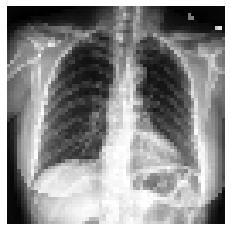

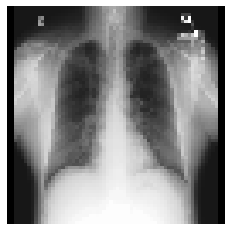

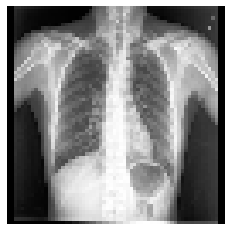

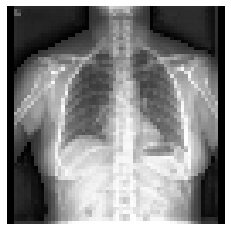

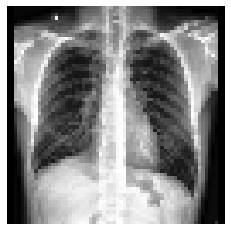

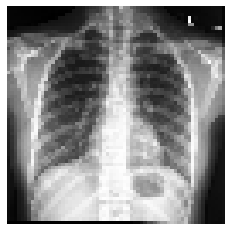

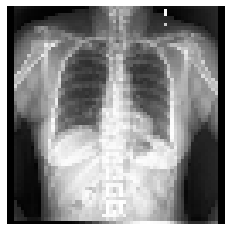

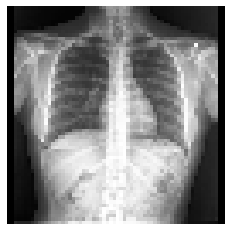

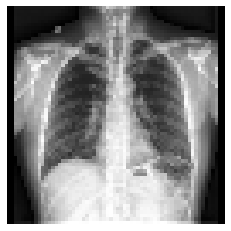

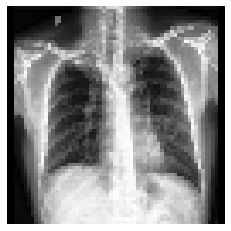

In [61]:
#fake_corpus = diffusion.sample(batch_size = 20)[-1]

real = XRAY_resized.to("cpu")
real,_ = train_test_split(real, train_size = 10, shuffle = True)
for i in range(10):
    plt.imshow(real[i][0], cmap="gray"), plt.axis("off")
    plt.show()

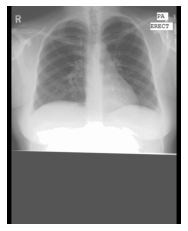

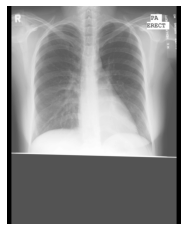

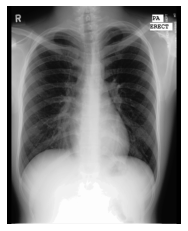

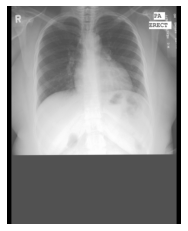

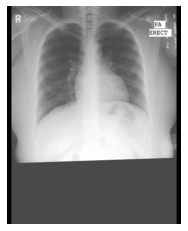

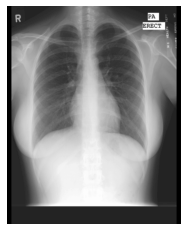

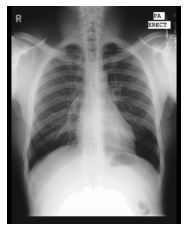

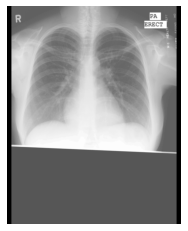

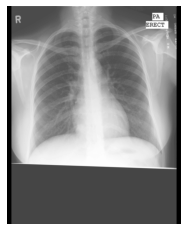

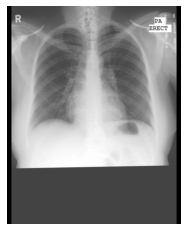

In [60]:
real_big = XRAY.to("cpu")
for i in range(600,610):
    plt.imshow(real_big[i][0], cmap="gray"), plt.axis("off")
    plt.show()

In [58]:
from PIL import Image
import torchvision.transforms as T
def imageMaker2000(tensor):
    transform = T.ToPILImage()
    img = transform(tensor)
    img.show()

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

x = XRAY[600]
imageMaker2000(x)

In [62]:
mIoU = torch.load("mIoU_20")
bl 

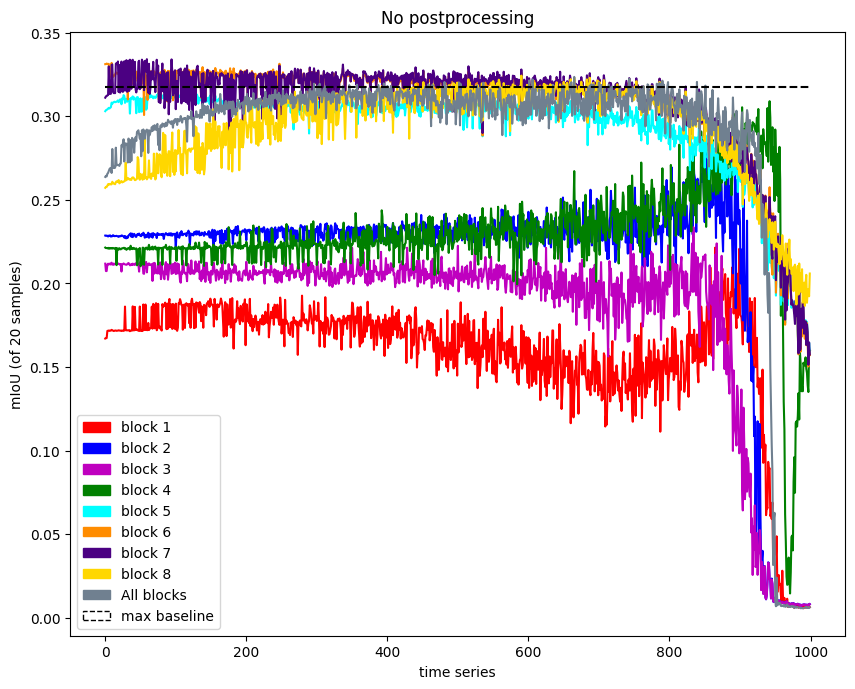

In [71]:
data_plotter(mIoU, bl, option = 0, n_samples=20, max_baseline=True)

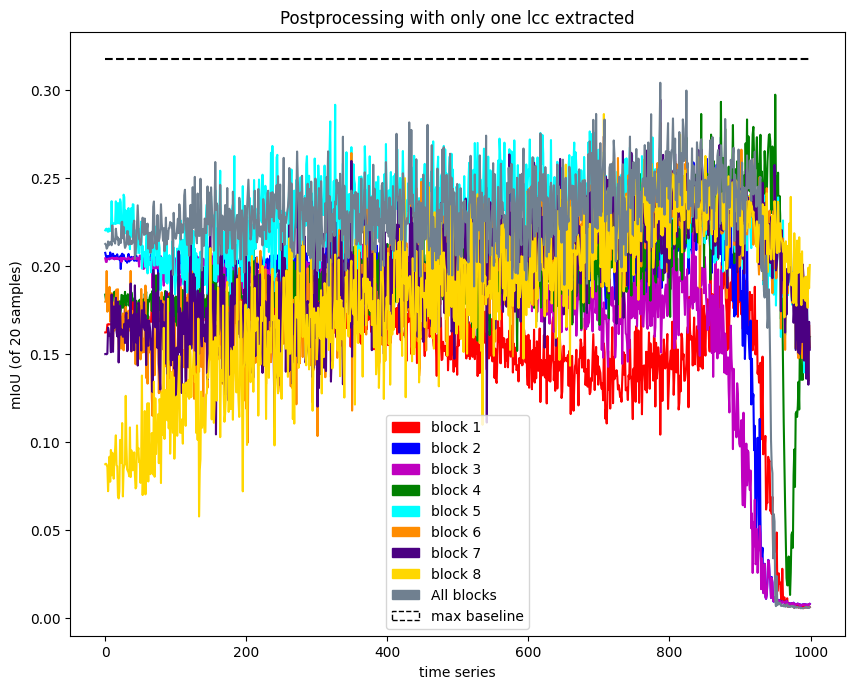

In [72]:
data_plotter(mIoU, bl, option = 1, n_samples=20, max_baseline=True)

In [302]:
option, block, t = np.unravel_index(mIoU.argmax(), mIoU.shape)
block = block + 1
print(option,block, t)

2 9 770
